In [1]:
from Utils.npz_to_df import *
from Utils.dataviz import *
from Utils.stationarity import *

In [2]:
#df creation from npz
folder_path = r"C:\Users\stebi\Desktop\potatoes\1800"
dataframes = load_npz_files(folder_path)
for name, df in dataframes.items():
    globals()[name] = df

In [3]:
df1

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x1792,x1793,x1794,x1795,x1796,x1797,x1798,x1799,x1800,y
0,97.256714,109.217660,108.177720,110.046720,111.929620,113.559700,115.110200,116.551600,117.922420,119.223114,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-69
1,135.700580,135.549320,135.346160,135.170640,135.020170,134.848880,134.601290,134.442780,134.242870,134.050780,...,9.868005,9.852276,9.816974,9.782293,9.700430,9.679945,9.688729,9.622552,9.602593,-69
2,9.578903,9.526599,9.494160,9.464470,9.434893,9.427804,9.392871,9.344328,9.308388,9.259672,...,-16.482183,-16.470444,-16.422170,-16.474878,-16.486914,-16.491713,-16.491026,-16.491032,-16.503109,-69
3,-16.513840,-16.533766,-16.540901,-16.550737,-16.553303,-16.564280,-16.555020,-16.554382,-16.578356,-16.570112,...,-27.333277,-27.337494,-27.349640,-27.378326,-27.389366,-27.373075,-27.376266,-27.378641,-27.393843,-69
4,-27.412397,-27.448242,-27.443336,-27.450314,-27.465702,-27.474468,-27.468273,-27.471638,-27.469805,-27.470478,...,-34.502663,-34.514355,-34.519485,-34.522392,-34.513977,-34.524544,-34.507244,-34.500763,-34.506233,-69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5706,-43.059860,-43.060944,-43.066000,-43.049225,-43.058987,-43.070698,-43.051693,-43.047090,-43.051006,-43.048805,...,-43.122772,-43.127860,-43.137302,-43.132412,-43.117374,-43.118380,-43.153930,-43.136320,-43.122925,50
5707,-43.133860,-43.124810,-43.122246,-43.128620,-43.138603,-43.110493,-43.118230,-43.114530,-43.151154,-43.126816,...,-43.235577,-43.234085,-43.226307,-43.226593,-43.229260,-43.223568,-43.221080,-43.225350,-43.232190,50
5708,-43.236350,-43.258070,-43.237976,-43.241530,-43.243073,-43.243843,-43.235367,-43.222744,-43.216045,-43.243088,...,-43.249615,-43.250040,-43.256466,-43.232464,-43.207592,-43.221073,-43.214375,-43.218887,-43.213074,50
5709,-43.188545,-43.185560,-43.217820,-43.215878,-43.198994,-43.224888,-43.216103,-43.216553,-43.229237,-43.215015,...,-43.296200,-43.268800,-43.289883,-43.305720,-43.284767,-43.293180,-43.303246,-43.298733,-43.310486,50


In [4]:
df32

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x1792,x1793,x1794,x1795,x1796,x1797,x1798,x1799,x1800,y
0,-30.770640,-33.980423,-33.078950,-33.179450,-33.302380,-33.306168,-33.294594,-33.294502,-33.338710,-33.266064,...,-33.484623,-33.714317,-33.754032,-33.524630,-33.390900,-33.321114,0.000000,0.000000,0.000000,-59
1,-33.245260,-33.207718,-33.295082,-33.540080,-33.527504,-33.440994,-33.426926,-33.365486,-33.541620,-33.428684,...,-32.730686,-32.684280,-32.648304,-32.638073,-32.635494,-32.641150,-32.630640,-32.643383,-32.610977,-59
2,-32.593422,-30.358680,-33.401700,-32.515373,-32.535145,-32.539658,-32.561690,-32.559845,-32.545235,-32.540200,...,-32.178368,-32.169907,-32.189014,-32.172250,-32.202705,-32.187820,-32.210007,-32.214810,-32.220097,-59
3,-32.228676,-32.243935,-32.254295,-32.256145,-32.257114,-32.253850,-32.245630,-32.243748,-32.293728,-32.349915,...,-33.140785,-33.141865,-33.130280,-33.135790,-33.124660,-33.101360,-33.078793,-33.054066,-33.066067,-59
4,-33.066160,-33.029760,-33.026203,-32.998478,-32.999706,-33.005135,-32.985794,-33.013160,-32.967945,-32.974510,...,-35.932003,-35.923367,-35.931942,-35.923004,-35.917380,-35.909830,-35.693447,-35.689910,-35.799480,-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5682,-46.202307,-46.202370,-46.202433,-46.202495,-46.202558,-46.202621,-46.202683,-46.202746,-46.202809,-46.202871,...,-46.314498,-46.314560,-46.314623,-46.314685,-46.314748,-46.314811,-46.314873,-46.314936,-46.314999,60
5683,-46.315061,-46.315124,-46.315187,-46.315249,-46.315312,-46.315375,-46.315437,-46.315500,-46.315562,-46.315625,...,-46.427251,-46.427314,-46.427377,-46.427439,-46.427502,-46.427565,-46.427627,-46.427690,-46.427753,60
5684,-46.427815,-46.427878,-46.427940,-46.428003,-46.428066,-46.428128,-46.428191,-46.428254,-46.428316,-46.428379,...,-46.540005,-46.540068,-46.540131,-46.540193,-46.540256,-46.540319,-46.540381,-46.540444,-46.540506,60
5685,-46.540569,-46.540632,-46.540694,-46.540757,-46.540820,-46.540882,-46.540945,-46.541008,-46.541070,-46.541133,...,-46.519726,-46.523857,-46.506245,-46.502632,-46.504677,-46.497433,-46.493725,-46.493202,-46.488330,60


In [5]:
#nans
dataframe_names = [f'df{i}' for i in range(1, 33)]
nan_report = {}

for name in dataframe_names:
    df = globals().get(name)
    if df is not None and isinstance(df, pd.DataFrame):
        nan_columns = df.columns[df.isna().any()].tolist()
        if nan_columns:
            nan_report[name] = nan_columns

if not nan_report:
    print("No nans.")
else:
    print("Nans in this df:")
    for name, columns in nan_report.items():
        print(f"{name} is column: {columns}")

No nans.


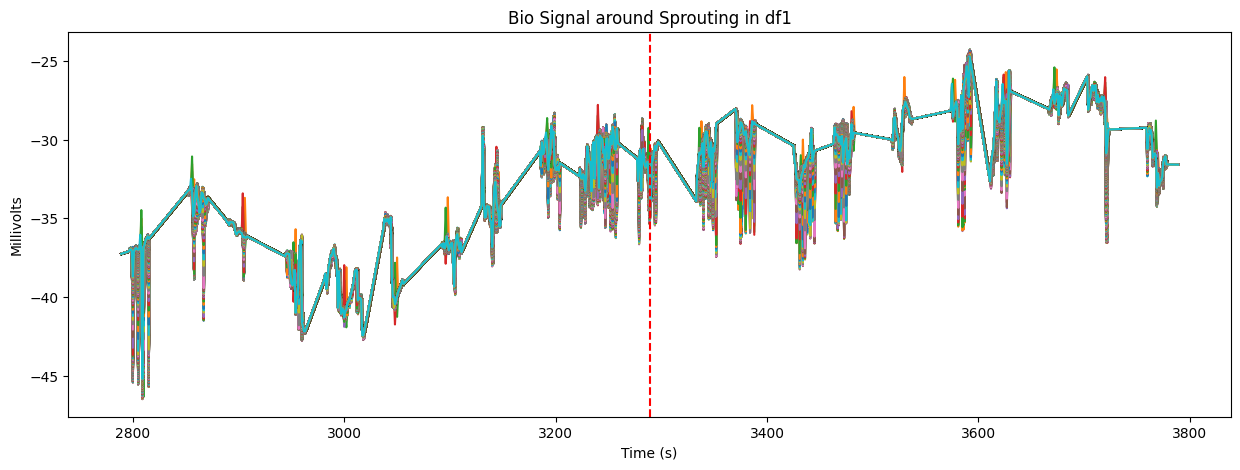

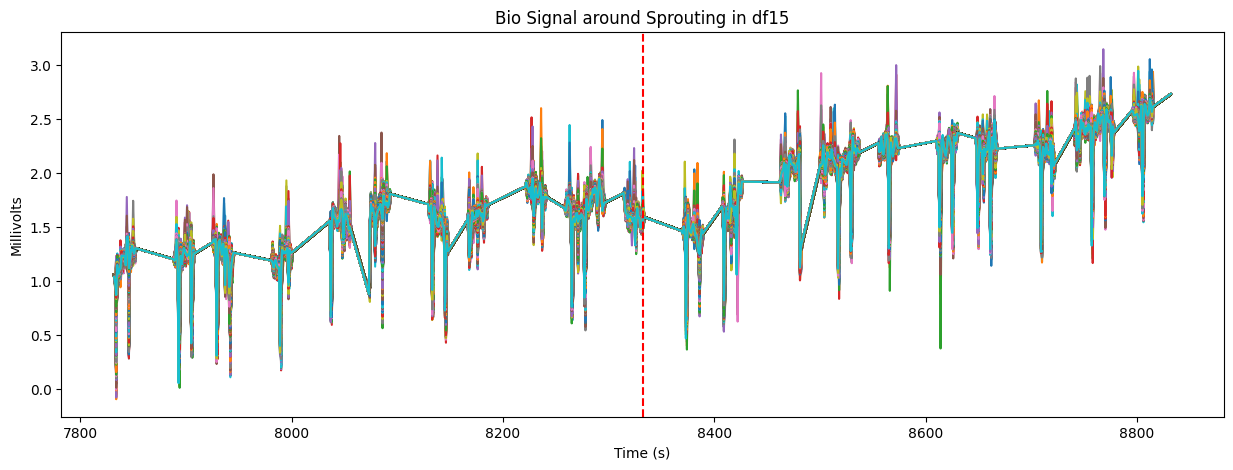

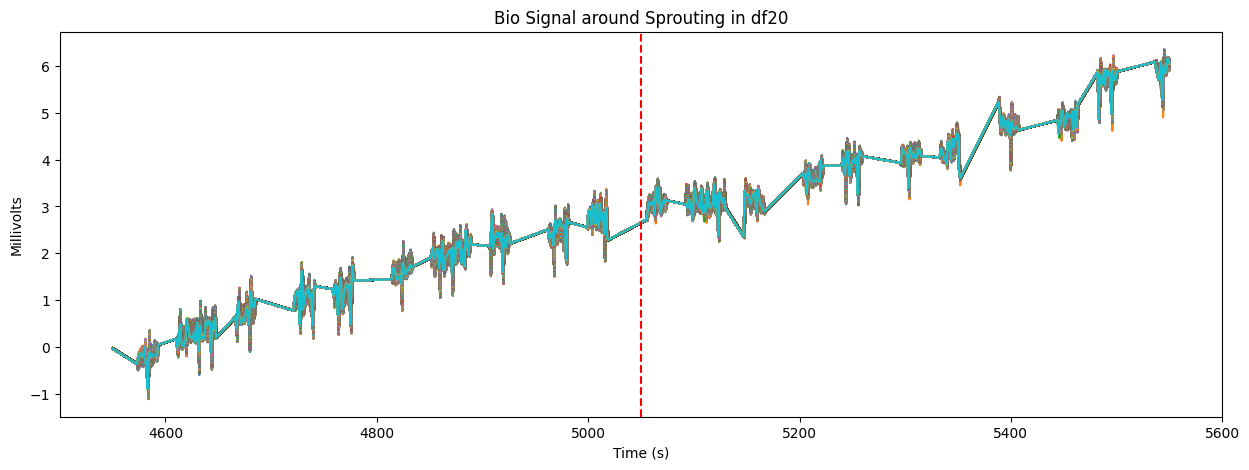

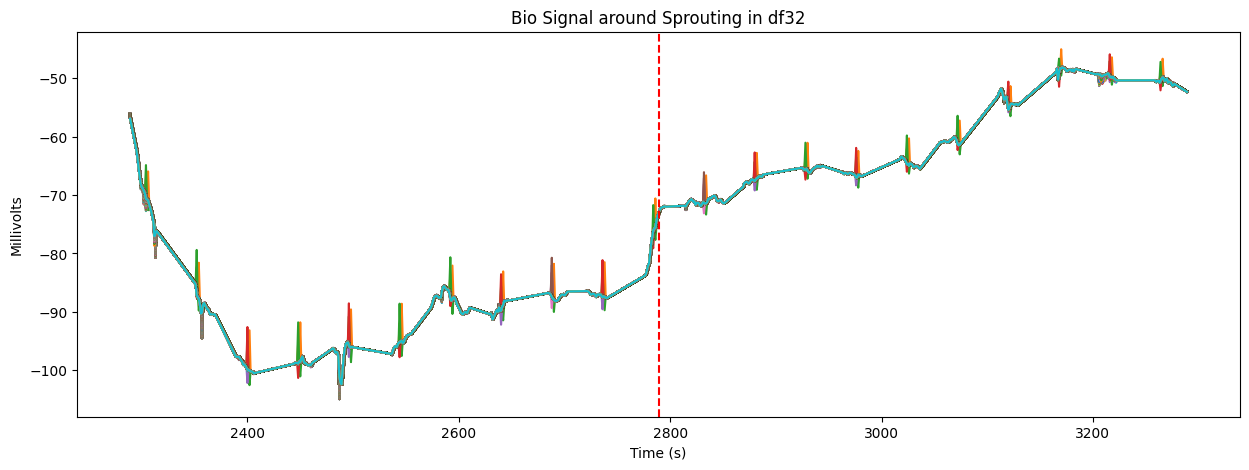

In [6]:
#500 steps before and after sprouting
plot_bio_signal(df1, 'df1')
plot_bio_signal(df15, 'df15')
plot_bio_signal(df20, 'df20')
plot_bio_signal(df32, 'df32')

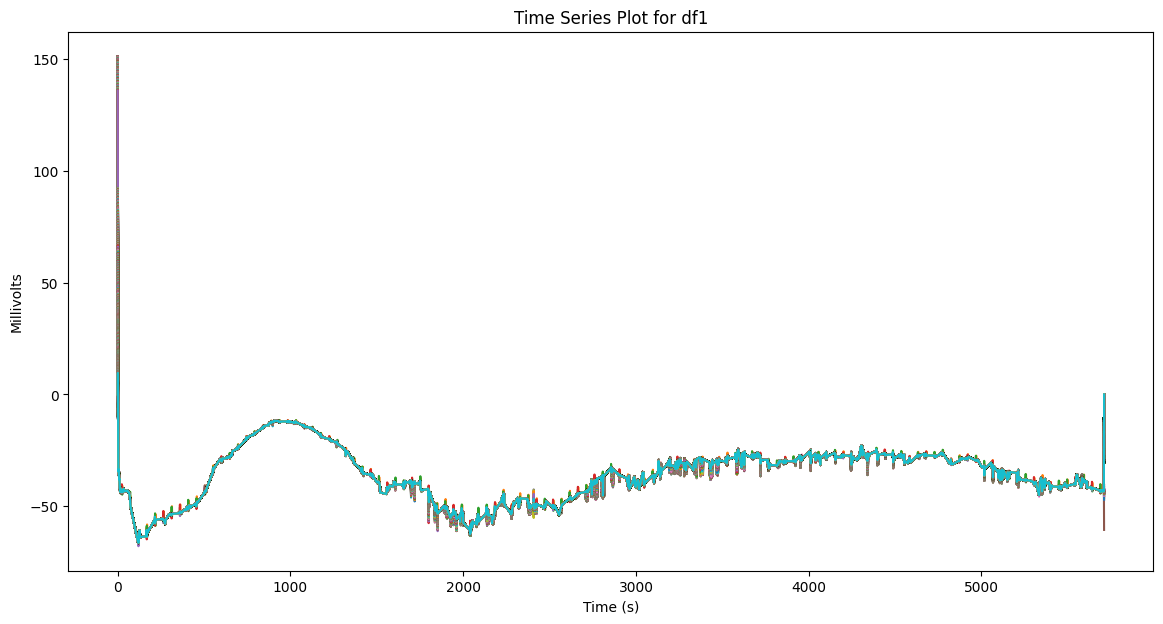

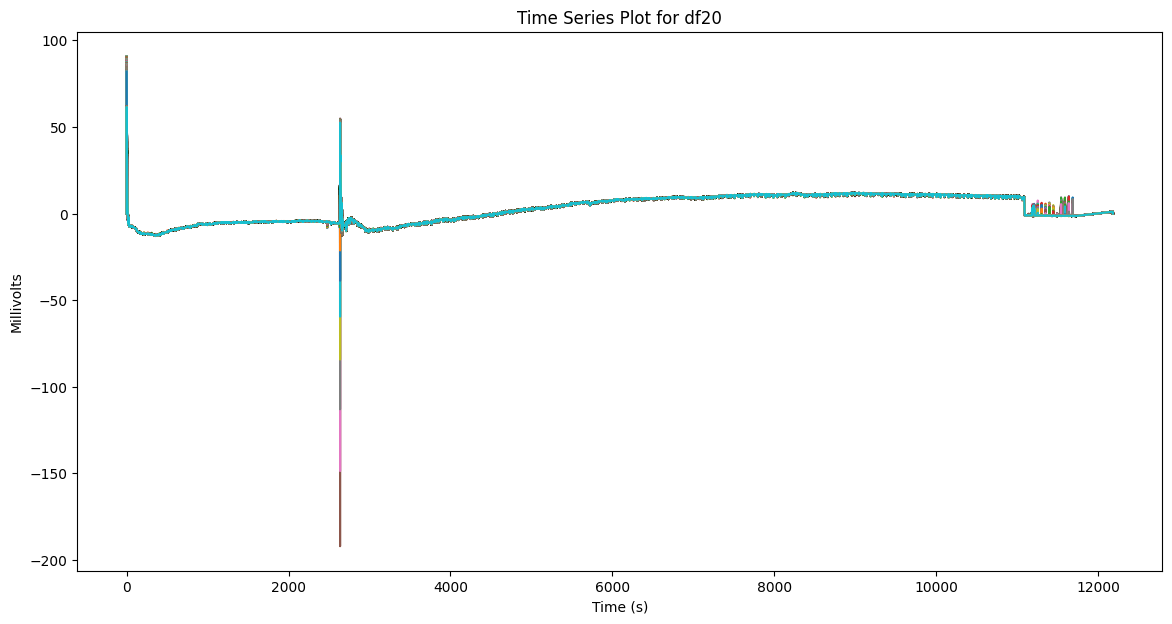

In [7]:
plot_time_series(df1, 'Time Series Plot for df1')
plot_time_series(df20, 'Time Series Plot for df20')

In [10]:
plot_heatmap_with_y(df1, 'Heatmap of Correlations for df1')
plot_heatmap_with_y(df20, 'Heatmap of Correlations for df20')

In [ ]:
#stationarity check
stationarity_results_df1 = check_stationarity(df1)
stationarity_results_df20 = check_stationarity(df20)

print("Stazionarietà dei segnali in df1:")
for column, result in stationarity_results_df1.items():
    print(f"Colonna: {column}")
    for key, value in result.items():
        print(f"  {key}: {value}")
    print()

print("Stazionarietà dei segnali in df20:")
for column, result in stationarity_results_df20.items():
    print(f"Colonna: {column}")
    for key, value in result.items():
        print(f"  {key}: {value}")
    print()


KeyboardInterrupt: 